# Earthquake Prediction

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
filepath = './data/earthquakes.csv'

In [3]:
df = pd.read_csv(filepath)
df = df[df.mag.notna()]
df.time = pd.to_datetime(df.time)
df = df[::-1]
df.head()

time   latitude   longitude    depth  \
4145808 2024-05-10 00:05:17.857000+00:00  61.670900 -150.126700  39.2000   
4145807 2024-05-10 00:09:08.588000+00:00  31.556000 -104.015000   7.0227   
4145806 2024-05-10 00:09:29.980000+00:00  38.827667 -122.803833   1.4600   
4145805 2024-05-10 00:18:19.660000+00:00  38.835333 -122.808833   2.3400   
4145804 2024-05-10 00:19:02.840000+00:00  19.256333 -155.370500  31.0600   

          mag magType   nst    gap      dmin   rms  ...  \
4145808  1.30      ml   NaN    NaN       NaN  0.94  ...   
4145807  1.50      ml  12.0   66.0  0.000000  0.10  ...   
4145806  0.78      md   9.0   77.0  0.006478  0.02  ...   
4145805  0.40      md   9.0   80.0  0.011960  0.01  ...   
4145804  2.42      ml  48.0  139.0  0.031650  0.12  ...   

                          updated                        place        type  \
4145808  2024-05-10T00:07:50.360Z   9 km SSW of Willow, Alaska  earthquake   
4145807  2024-05-10T20:07:01.709Z     34 km NW of Toyah, Texas  earthquake   
4145806  2024-05-10T00:11:04.136Z  7 km NNW of The Geysers, CA  earthquake   
4145805  2024-05-10T09:56:42.863Z         8 km WNW of Cobb, CA  earthquake   
4145804  2024-05-13T04:40:20.040Z  12 km ENE of Pāhala, Hawaii  earthquake   

        horizontalError depthError  magError  magNst     status  \
4145808             NaN   4.200000       NaN     NaN  automatic   
4145807        1.231006   0.984001  0.000000     6.0   reviewed   
4145806        0.430000   1.090000  0.140000    10.0  automatic   
4145805        0.540000   1.250000  0.107000     8.0   reviewed   
4145804        0.410000   0.550000  0.244982    25.0   reviewed   

         locationSource magSource  
4145808              ak        ak  
4145807              tx        tx  
4145806              nc        nc  
4145805              nc        nc  
4145804              hv        hv  

[5 rows x 22 columns]

In [4]:
df.describe()

latitude     longitude         depth           mag           nst  \
count  3.992177e+06  3.992177e+06  3.991602e+06  3.992177e+06  2.849094e+06   
mean   3.635638e+01 -1.008879e+02  2.251808e+01  1.843615e+00  1.749320e+01   
std    2.002546e+01  7.764114e+01  5.497220e+01  1.326399e+00  2.528928e+01   
min   -8.442200e+01 -1.799997e+02 -1.000000e+01 -9.990000e+00  0.000000e+00   
25%    3.367250e+01 -1.461915e+02  3.380000e+00  9.600000e-01  6.000000e+00   
50%    3.759050e+01 -1.189532e+02  7.600000e+00  1.500000e+00  1.200000e+01   
75%    4.505667e+01 -1.159703e+02  1.557000e+01  2.390000e+00  2.100000e+01   
max    8.738600e+01  1.800000e+02  7.358000e+02  9.500000e+00  9.340000e+02   

                gap          dmin           rms  horizontalError  \
count  2.954708e+06  2.324076e+06  3.802463e+06     2.210624e+06   
mean   1.278350e+02  3.505479e-01  3.008869e-01     1.418998e+00   
std    6.913505e+01  1.614478e+00  3.600676e-01     3.286022e+00   
min    0.000000e+00  0.000000e+00 -1.000000e+00     0.000000e+00   
25%    7.600000e+01  2.153000e-02  7.000000e-02     2.900000e-01   
50%    1.119000e+02  5.314000e-02  1.510000e-01     4.800000e-01   
75%    1.650000e+02  1.225000e-01  4.500000e-01     9.700000e-01   
max    3.600000e+02  1.411600e+02  1.043300e+02     2.554407e+02   

         depthError      magError        magNst  
count  3.522135e+06  2.131649e+06  2.892908e+06  
mean   4.630987e+00  1.840492e-01  1.283754e+01  
std    1.017026e+03  2.320043e-01  2.194237e+01  
min   -1.000000e+00  0.000000e+00  0.000000e+00  
25%    4.600000e-01  9.300000e-02  3.000000e+00  
50%    8.700000e-01  1.500000e-01  7.000000e+00  
75%    2.100000e+00  2.170000e-01  1.400000e+01  
max    1.773552e+06  6.190000e+00  8.840000e+02

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3992177 entries, 4145808 to 2
Data columns (total 22 columns):
 #   Column           Dtype              
---  ------           -----              
 0   time             datetime64[ns, UTC]
 1   latitude         float64            
 2   longitude        float64            
 3   depth            float64            
 4   mag              float64            
 5   magType          object             
 6   nst              float64            
 7   gap              float64            
 8   dmin             float64            
 9   rms              float64            
 10  net              object             
 11  id               object             
 12  updated          object             
 13  place            object             
 14  type             object             
 15  horizontalError  float64            
 16  depthError       float64            
 17  magError         float64            
 18  magNst           float64            
 19  statu

In [6]:
df.isnull().sum()

time                     0
latitude                 0
longitude                0
depth                  575
mag                      0
magType              10407
nst                1143083
gap                1037469
dmin               1668101
rms                 189714
net                      0
id                       0
updated                  0
place                    0
type                     0
horizontalError    1781553
depthError          470042
magError           1860528
magNst             1099269
status                   0
locationSource           0
magSource                0
dtype: int64

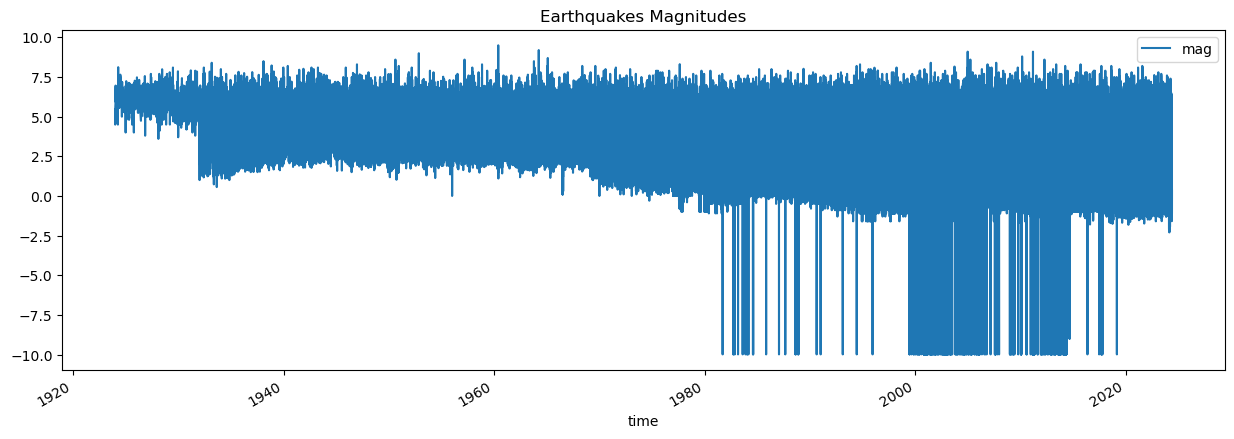

In [7]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', x='time', y='mag')
plt.show()

/var/folders/_0/wfq3vrsj7pvcsxqlxwqbx6k40000gn/T/ipykernel_38371/2795508281.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')


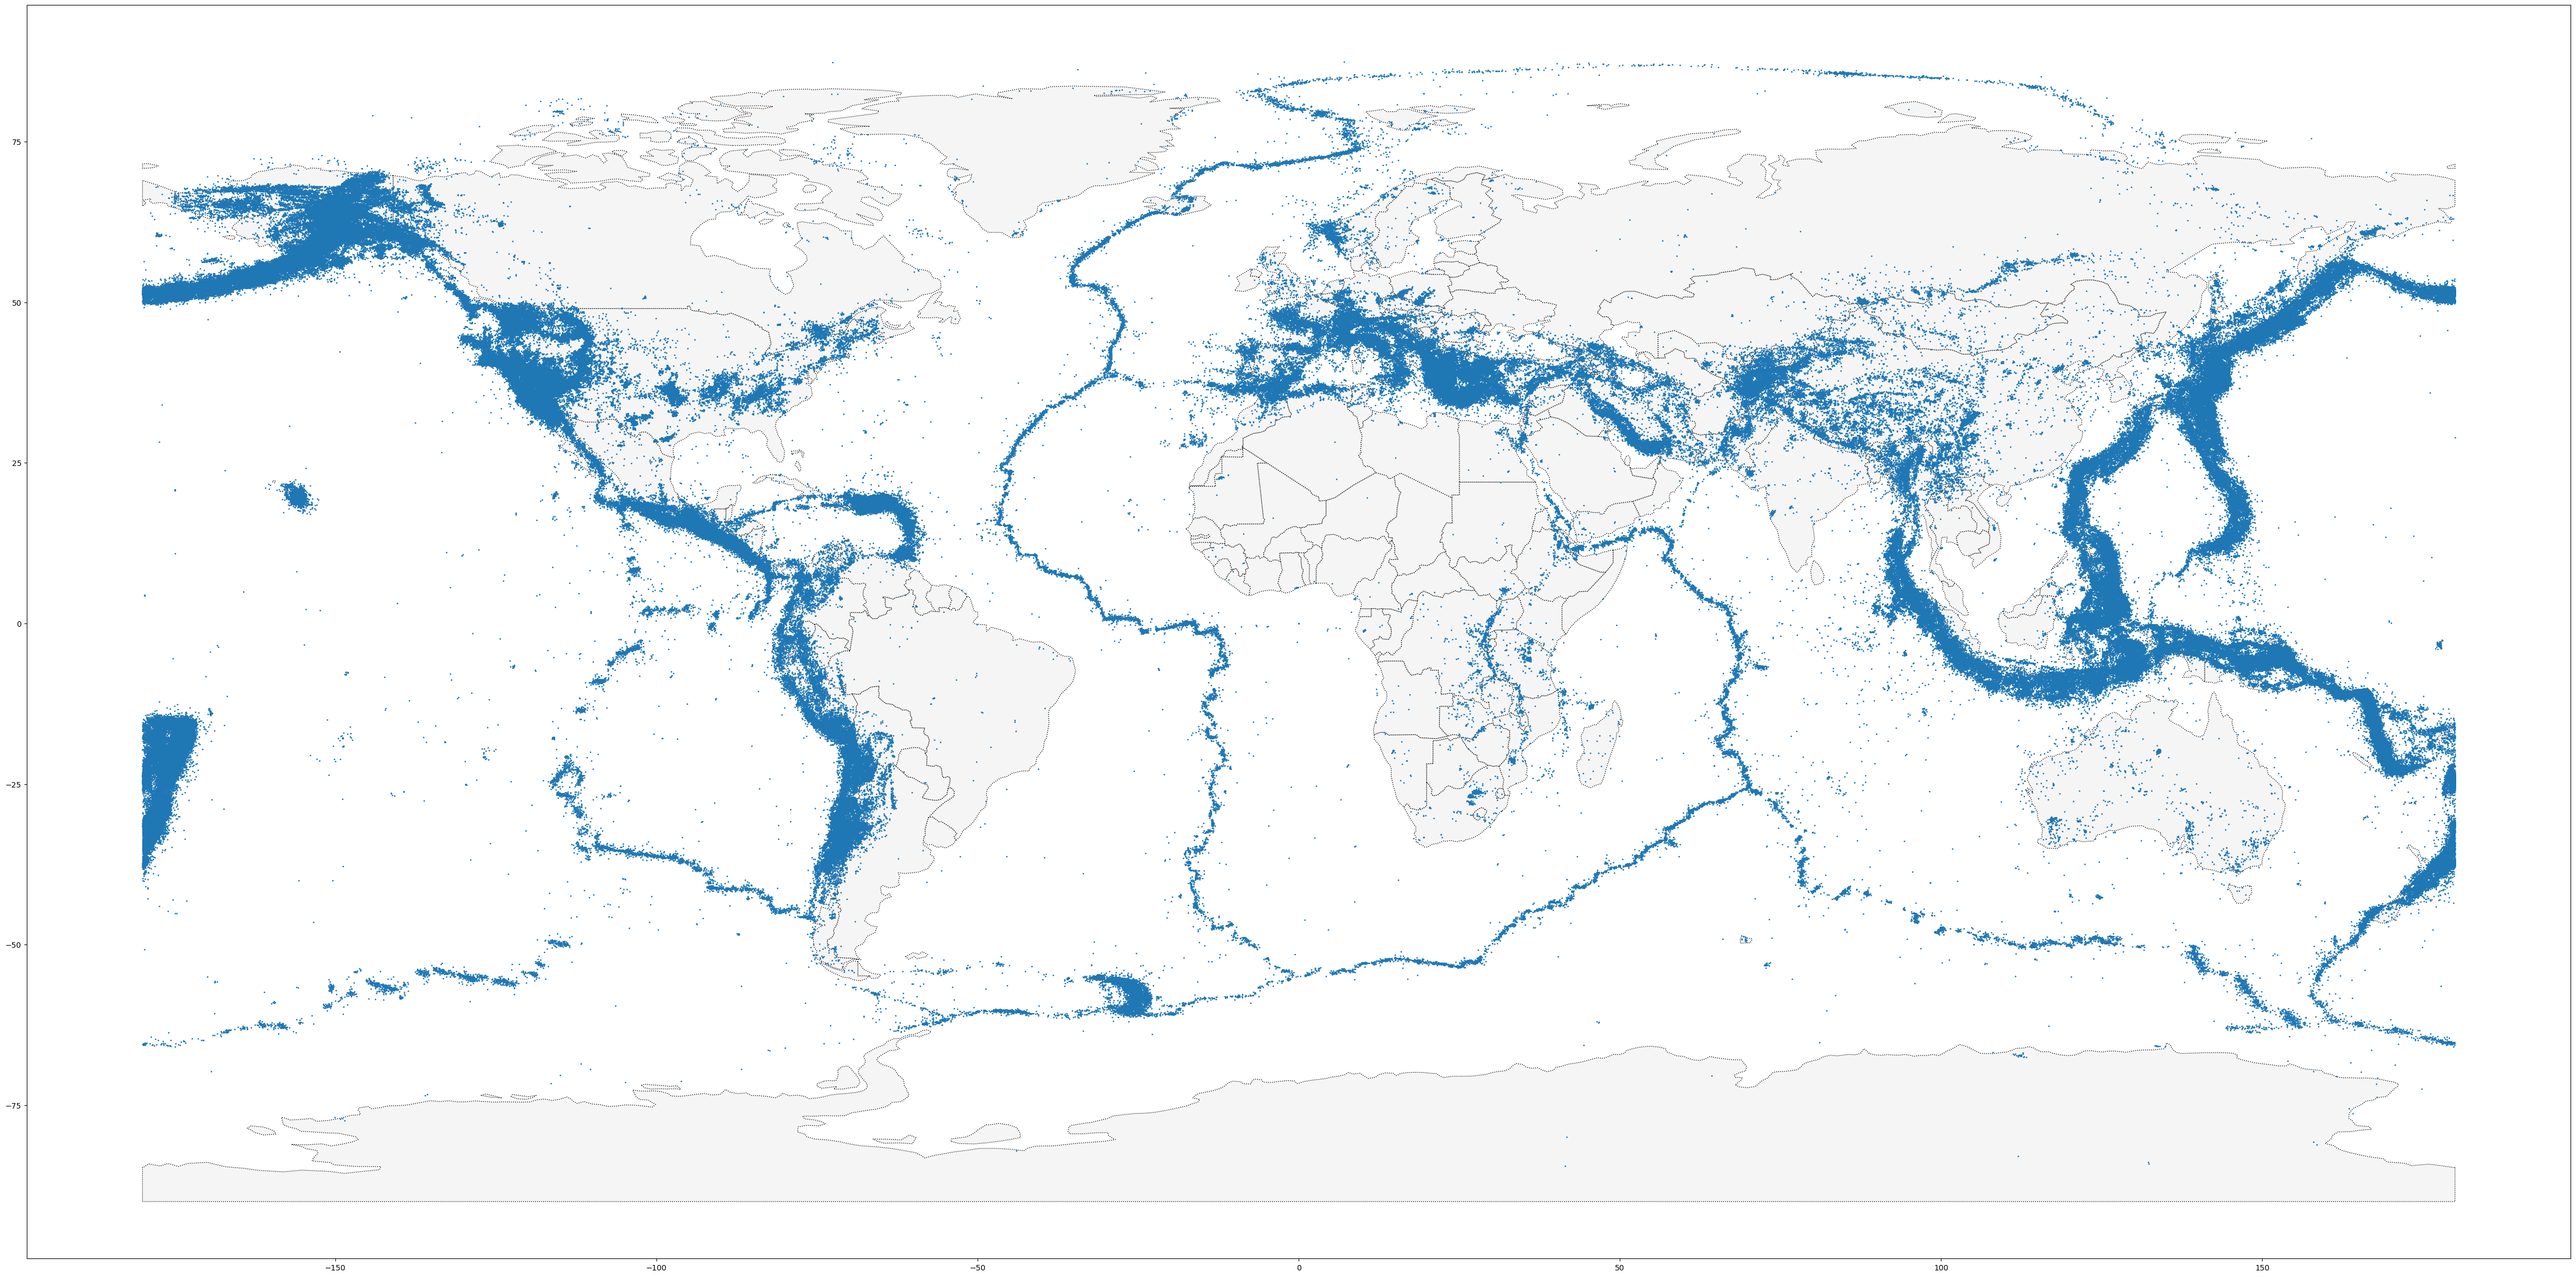

In [8]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [207]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


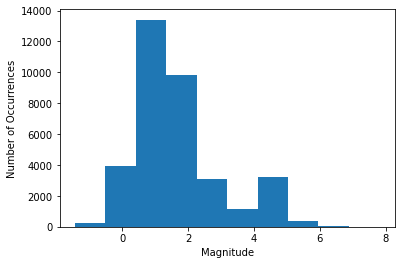

In [208]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

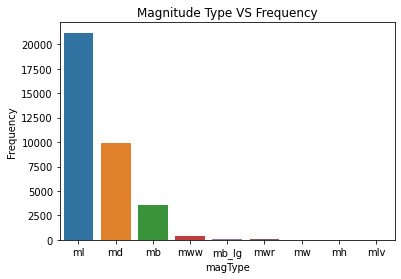

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [209]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [210]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

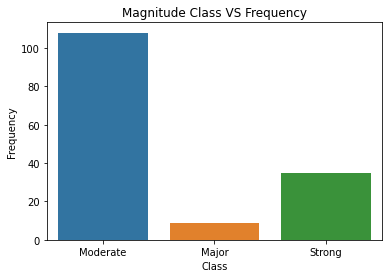

In [211]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

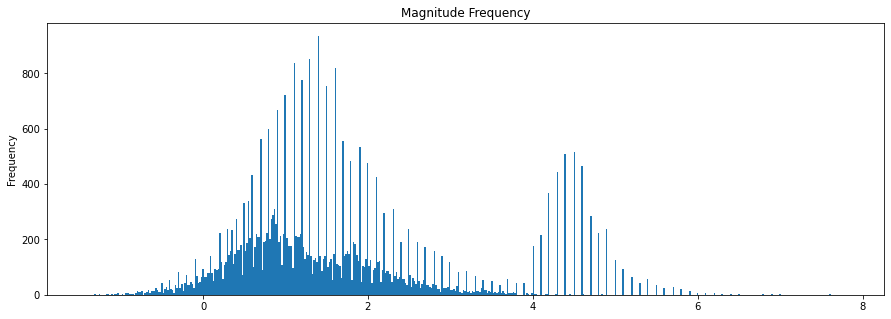

In [212]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.title('Magnitude Frequency')
plt.show()

In [213]:
threshold = 0.9
corr_matrix = df.corr() 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

/var/folders/5k/d7ys19gs271bht03kns2zr3c0000gn/T/ipykernel_20014/1073417915.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [214]:
percent = 30
df = df.dropna(axis=1, thresh=int(((100 - percent) / 100) * df.shape[0] + 1)) 

In [215]:
df = df.copy()
df['location'] = df.place.str.split(', ', expand=True)[1]
df.location.head() 

35244    Alaska
35243        CA
35242        CA
35241    Alaska
35240        CA
Name: location, dtype: object

In [216]:
print(f'Total locations: {df.location.nunique()}')

Total locations: 134


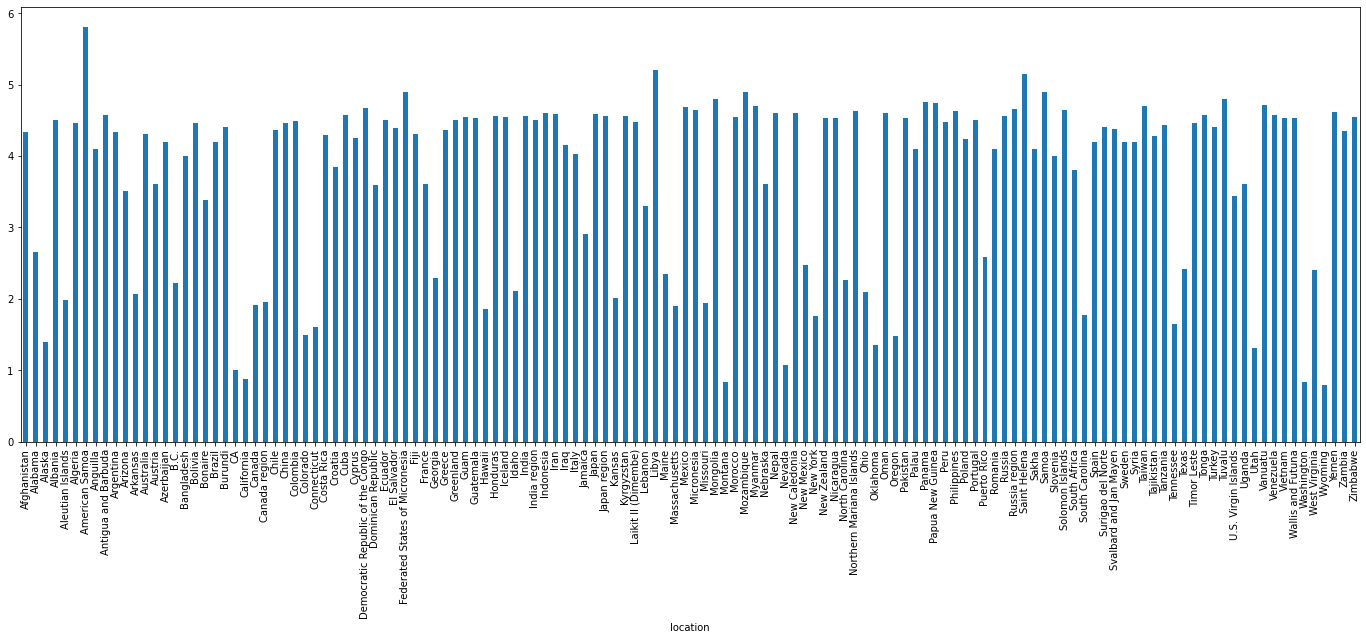

In [217]:
df.groupby(['location'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

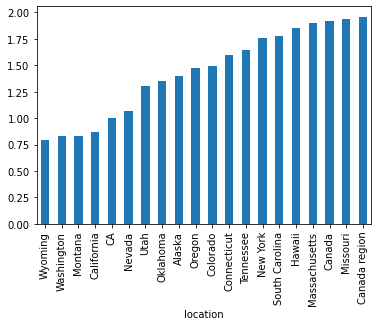

In [218]:
df.groupby(['location'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

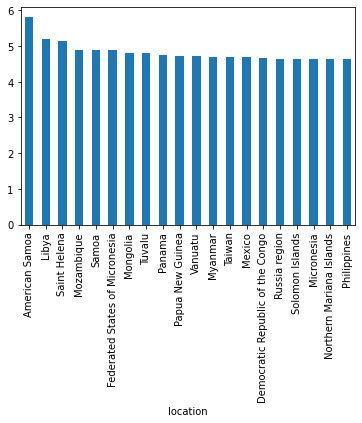

In [219]:
df.groupby(['location'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [220]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.time.dt.hour
    df['dayofweek'] = df.time.dt.dayofweek
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    df['dayofmonth'] = df.time.dt.day
    df['weekofyear'] = df.time.dt.isocalendar().week
    df['quarter'] = df.time.dt.quarter
    df['season'] = df.month % 12 // 3 + 1
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_lag'] = df.mag.shift(5)
    df['mag_10eq_lag'] = df.mag.shift(10)
    df['mag_15eq_lag'] = df.mag.shift(15)

    df['depth_5eq_lag'] = df.depth.shift(5)
    df['depth_10eq_lag'] = df.depth.shift(10)
    df['depth_15eq_lag'] = df.depth.shift(15)
    return df

def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_avg'] = df.mag.rolling(window=5, center=False).mean()
    df['mag_10eq_avg'] = df.mag.rolling(window=10, center=False).mean()
    df['mag_15eq_avg'] = df.mag.rolling(window=15, center=False).mean()
    df['mag_5eq_min'] = df.mag.rolling(window=5, center=False).min()
    df['mag_10eq_min'] = df.mag.rolling(window=10, center=False).min()
    df['mag_15eq_min'] = df.mag.rolling(window=15, center=False).min()
    df['mag_5eq_max'] = df.mag.rolling(window=5, center=False).max()
    df['mag_10eq_max'] = df.mag.rolling(window=10, center=False).max()
    df['mag_15eq_max'] = df.mag.rolling(window=15, center=False).max()
    df['mag_5eq_std'] = df.mag.rolling(window=5, center=False).std()
    df['mag_10eq_std'] = df.mag.rolling(window=10, center=False).std()
    df['mag_15eq_std'] = df.mag.rolling(window=15, center=False).std()

    df['depth_5eq_avg'] = df.depth.rolling(window=5, center=False).mean()
    df['depth_10eq_avg'] = df.depth.rolling(window=10, center=False).mean()
    df['depth_15eq_avg'] = df.depth.rolling(window=15, center=False).mean()
    df['depth_5eq_min'] = df.depth.rolling(window=5, center=False).min()
    df['depth_10eq_min'] = df.depth.rolling(window=10, center=False).min()
    df['depth_15eq_min'] = df.depth.rolling(window=15, center=False).min()
    df['depth_5eq_max'] = df.depth.rolling(window=5, center=False).max()
    df['depth_10eq_max'] = df.depth.rolling(window=10, center=False).max()
    df['depth_15eq_max'] = df.depth.rolling(window=15, center=False).max()
    df['depth_5eq_std'] = df.depth.rolling(window=5, center=False).std()
    df['depth_10eq_std'] = df.depth.rolling(window=10, center=False).std()
    df['depth_15eq_std'] = df.depth.rolling(window=15, center=False).std()
    return df

data = []
for location in df.location.unique():
    temp = df.loc[df.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

df = pd.concat(data)

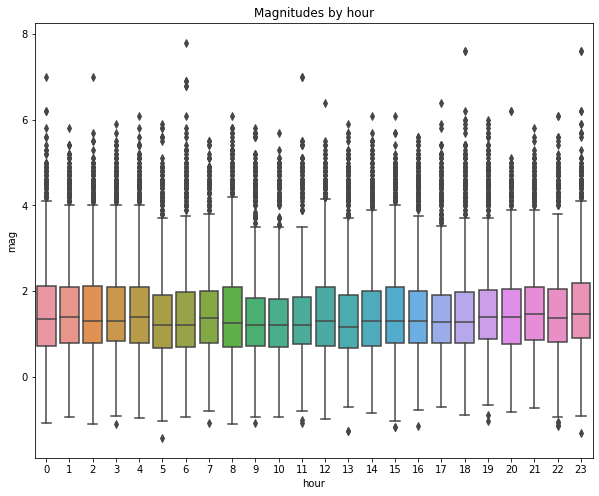

In [221]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

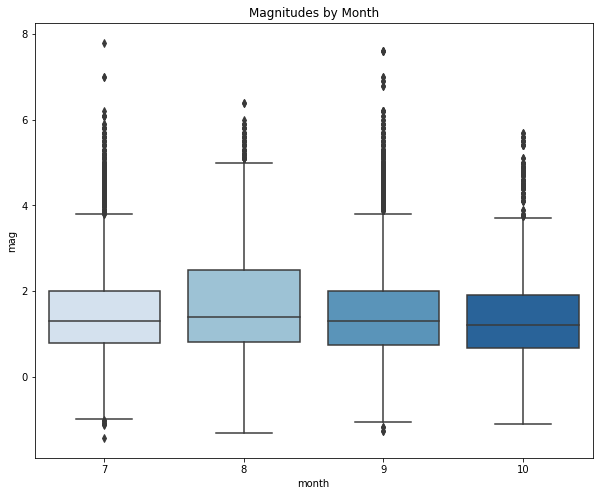

In [222]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [223]:
features = [
    'dayofyear',
    'hour',
    'dayofweek',
    'month',
    'season',
    'year',
    'mag_5eq_lag',
    'mag_10eq_lag',
    'mag_15eq_lag',
    'mag_5eq_avg',
    'mag_10eq_avg',
    'mag_15eq_avg',
    'mag_5eq_min',
    'mag_10eq_min',
    'mag_15eq_min',
    'mag_5eq_max',
    'mag_10eq_max',
    'mag_15eq_max',
    'mag_5eq_std',
    'mag_10eq_std',
    'mag_15eq_std',
    'depth_5eq_lag',
    'depth_10eq_lag',
    'depth_15eq_lag',
    'depth_5eq_avg',
    'depth_10eq_avg',
    'depth_15eq_avg',
    'depth_5eq_min',
    'depth_10eq_min',
    'depth_15eq_min',
    'depth_5eq_max',
    'depth_10eq_max',
    'depth_15eq_max',
    'depth_5eq_std',
    'depth_10eq_std',
    'depth_15eq_std',
    'latitude',
    'longitude',
]
cat_features = ['location']
target = 'mag'

In [224]:
date = '2022-09-25 00:00:00.000000+00:00'

df_train = df.loc[df.time < date]
df_test = df.loc[df.time >= date]

In [225]:
print(f'Test size: {len(df_test) / (len(df_test) + len(df_train))}')

Test size: 0.20542683682319415


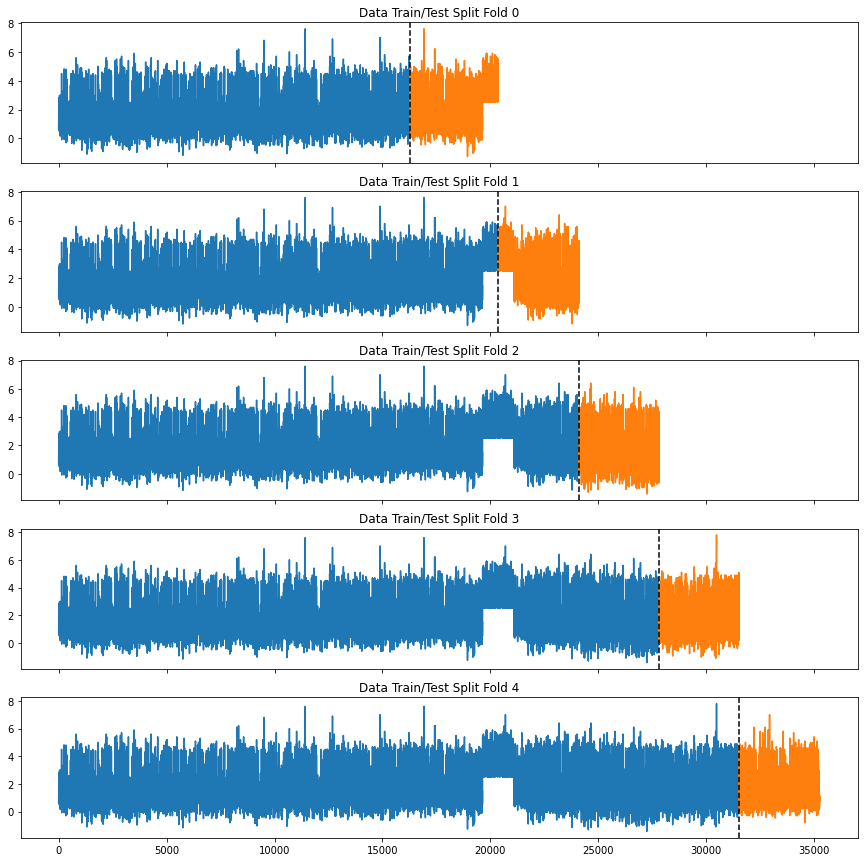

In [226]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [227]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50,
        cat_features=cat_features,
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.1715721	test: 1.1715721	test1: 1.5351445	best: 1.5351445 (0)	total: 23.6ms	remaining: 23.6s
100:	learn: 0.6882549	test: 0.6882549	test1: 0.7628883	best: 0.7628883 (100)	total: 1.73s	remaining: 15.4s
200:	learn: 0.5549258	test: 0.5549258	test1: 0.5539505	best: 0.5539505 (200)	total: 3.38s	remaining: 13.4s
300:	learn: 0.5130914	test: 0.5130914	test1: 0.5035534	best: 0.5035534 (300)	total: 4.99s	remaining: 11.6s
400:	learn: 0.4927518	test: 0.4927518	test1: 0.4863213	best: 0.4863213 (400)	total: 6.52s	remaining: 9.74s
500:	learn: 0.4778229	test: 0.4778229	test1: 0.4778893	best: 0.4778893 (500)	total: 7.8s	remaining: 7.77s
600:	learn: 0.4648306	test: 0.4648306	test1: 0.4719137	best: 0.4719137 (600)	total: 9.25s	remaining: 6.14s
700:	learn: 0.4537154	test: 0.4537154	test1: 0.4677258	best: 0.4677258 (700)	total: 10.8s	remaining: 4.6s
800:	learn: 0.4436629	test: 0.4436629	test1: 0.4640182	best: 0.4640076 (799)	total: 12.1s	remaining: 3s
900:	learn: 0.4339381	test: 0.4339381	test1: 

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2461312	test: 1.2461312	test1: 1.4036838	best: 1.4036838 (0)	total: 22.9ms	remaining: 22.9s
100:	learn: 0.7021854	test: 0.7021854	test1: 0.7746606	best: 0.7746606 (100)	total: 1.58s	remaining: 14s
200:	learn: 0.5546319	test: 0.5546319	test1: 0.6181615	best: 0.6181615 (200)	total: 3.2s	remaining: 12.7s
300:	learn: 0.5094693	test: 0.5094693	test1: 0.5872485	best: 0.5872485 (300)	total: 4.81s	remaining: 11.2s
400:	learn: 0.4883567	test: 0.4883567	test1: 0.5803326	best: 0.5803326 (400)	total: 6.79s	remaining: 10.2s
500:	learn: 0.4738643	test: 0.4738643	test1: 0.5769145	best: 0.5769145 (500)	total: 8.43s	remaining: 8.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5767230771
bestIteration = 514

Shrink model to first 515 iterations.


/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2740596	test: 1.2740596	test1: 1.1117461	best: 1.1117461 (0)	total: 57ms	remaining: 57s
100:	learn: 0.7156211	test: 0.7156211	test1: 0.7499518	best: 0.7499518 (100)	total: 1.87s	remaining: 16.6s
200:	learn: 0.5672096	test: 0.5672096	test1: 0.6630904	best: 0.6628873 (198)	total: 3.82s	remaining: 15.2s
300:	learn: 0.5257113	test: 0.5257113	test1: 0.6517133	best: 0.6490160 (282)	total: 5.59s	remaining: 13s
400:	learn: 0.5053338	test: 0.5053338	test1: 0.6449118	best: 0.6438478 (371)	total: 7.68s	remaining: 11.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6438478393
bestIteration = 371

Shrink model to first 372 iterations.


/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2520965	test: 1.2520965	test1: 1.0608241	best: 1.0608241 (0)	total: 36.4ms	remaining: 36.3s
100:	learn: 0.7183382	test: 0.7183382	test1: 0.7316673	best: 0.7316673 (100)	total: 1.91s	remaining: 17s
200:	learn: 0.5815176	test: 0.5815176	test1: 0.6572511	best: 0.6572511 (200)	total: 3.65s	remaining: 14.5s
300:	learn: 0.5408813	test: 0.5408813	test1: 0.6276509	best: 0.6276509 (300)	total: 5.39s	remaining: 12.5s
400:	learn: 0.5209644	test: 0.5209644	test1: 0.6129000	best: 0.6129000 (400)	total: 7.13s	remaining: 10.7s
500:	learn: 0.5076577	test: 0.5076577	test1: 0.6026853	best: 0.6026853 (500)	total: 8.93s	remaining: 8.89s
600:	learn: 0.4965848	test: 0.4965848	test1: 0.5945982	best: 0.5945982 (600)	total: 10.6s	remaining: 7.07s
700:	learn: 0.4870814	test: 0.4870814	test1: 0.5879228	best: 0.5879228 (700)	total: 12.4s	remaining: 5.3s
800:	learn: 0.4790859	test: 0.4790859	test1: 0.5834336	best: 0.5833847 (798)	total: 14.2s	remaining: 3.52s
900:	learn: 0.4717388	test: 0.4717388	test1

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.2294358	test: 1.2294358	test1: 1.0158726	best: 1.0158726 (0)	total: 34.6ms	remaining: 34.6s
100:	learn: 0.7205594	test: 0.7205594	test1: 0.6503048	best: 0.6503048 (100)	total: 1.93s	remaining: 17.2s
200:	learn: 0.5896948	test: 0.5896948	test1: 0.5713418	best: 0.5713418 (200)	total: 3.74s	remaining: 14.9s
300:	learn: 0.5485434	test: 0.5485434	test1: 0.5519222	best: 0.5519222 (300)	total: 5.62s	remaining: 13.1s
400:	learn: 0.5274919	test: 0.5274919	test1: 0.5414858	best: 0.5414858 (400)	total: 7.46s	remaining: 11.1s
500:	learn: 0.5139563	test: 0.5139563	test1: 0.5346216	best: 0.5345845 (499)	total: 9.26s	remaining: 9.22s
600:	learn: 0.5038980	test: 0.5038980	test1: 0.5298922	best: 0.5298922 (600)	total: 11.1s	remaining: 7.36s
700:	learn: 0.4954606	test: 0.4954606	test1: 0.5256914	best: 0.5256785 (699)	total: 12.9s	remaining: 5.52s
800:	learn: 0.4878227	test: 0.4878227	test1: 0.5217811	best: 0.5217811 (800)	total: 14.7s	remaining: 3.66s
900:	learn: 0.4807931	test: 0.4807931	te

In [228]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.5538798926752821
Fold scores:[0.45739479925054266, 0.5767230773446841, 0.6438478390013102, 0.5774080477620421, 0.5140257000178313]


In [229]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [230]:
grid = {
    'depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1500],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0136705	test: 1.9827374	best: 1.9827374 (0)	total: 10.6ms	remaining: 15.8s
1:	learn: 1.9961311	test: 1.9655183	best: 1.9655183 (1)	total: 18.5ms	remaining: 13.8s
2:	learn: 1.9784627	test: 1.9479215	best: 1.9479215 (2)	total: 27.9ms	remaining: 13.9s
3:	learn: 1.9611527	test: 1.9308042	best: 1.9308042 (3)	total: 33.7ms	remaining: 12.6s
4:	learn: 1.9445772	test: 1.9145542	best: 1.9145542 (4)	total: 41.9ms	remaining: 12.5s
5:	learn: 1.9278712	test: 1.8979928	best: 1.8979928 (5)	total: 51.4ms	remaining: 12.8s
6:	learn: 1.9112618	test: 1.8814956	best: 1.8814956 (6)	total: 60.3ms	remaining: 12.9s
7:	learn: 1.8946011	test: 1.8650418	best: 1.8650418 (7)	total: 66.9ms	remaining: 12.5s
8:	learn: 1.8781589	test: 1.8487570	best: 1.8487570 (8)	total: 75.2ms	remaining: 12.5s
9:	learn: 1.8624373	test: 1.8333293	best: 1.8333293 (9)	total: 80.9ms	remaining: 12.1s
10:	learn: 1.8464711	test: 1.8174198	best: 1.8174198 (10)	total: 86.8ms	remaining: 11.8s
11:	learn: 1.8305151	test: 1.8017210	best

In [231]:
grid_search_result['params']

{'depth': 7, 'iterations': 1500, 'learning_rate': 0.05}

In [232]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8606493040319891
Mean Absolute Error: 0.3416868219572702
Root Mean Squared Error: 0.45973840885893463


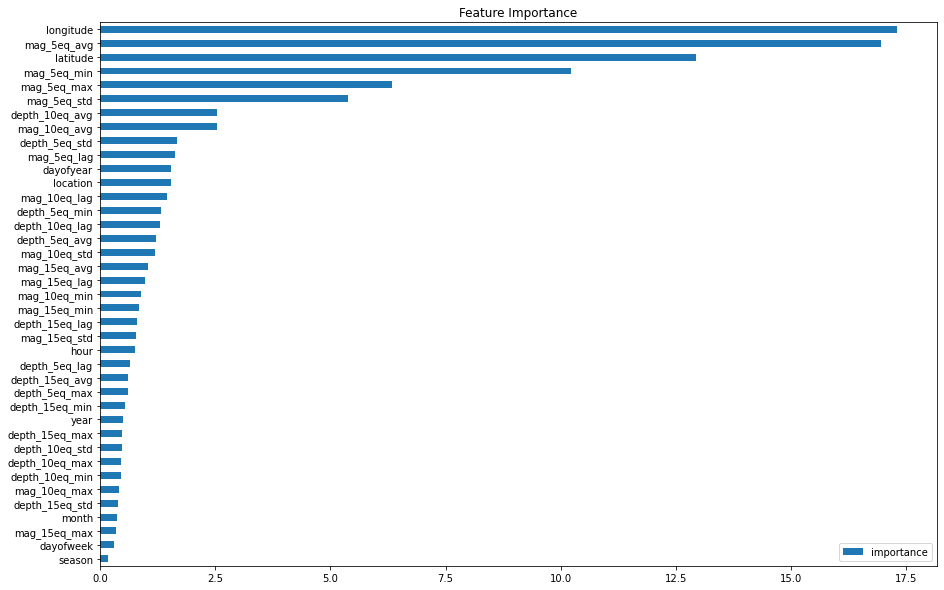

In [233]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Accuracy of Model: 0.8291690829279594
Mean Absolute Error: 0.34458523578380035
Root Mean Squared Error: 0.4697411059610845


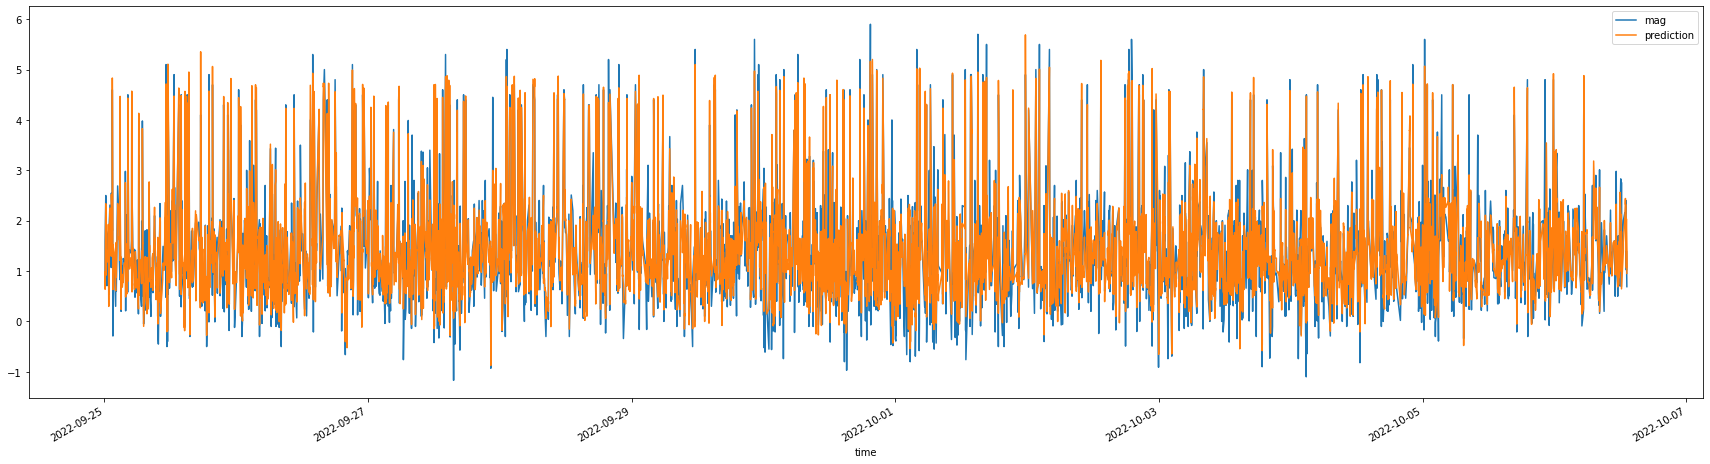

In [245]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'time': df_test.time, 'mag': df_test[target], 'prediction': prediction})
df_plot = df_plot.sort_values(by='time')
df_plot.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [248]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data.time = pd.to_datetime(live_data.time)
live_data['location'] = live_data.place.str.split(', ', expand=True)[1]
live_data = live_data[::-1]

In [249]:
data = []
for location in live_data.location.unique():
    temp = live_data.loc[live_data.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

live_data = pd.concat(data)

/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/anan/opt/miniconda3/envs/earthquake-prediction/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Accuracy of Model: 0.782088122175113
Mean Absolute Error: 0.39340243482955906
Root Mean Squared Error: 0.5289957045091795


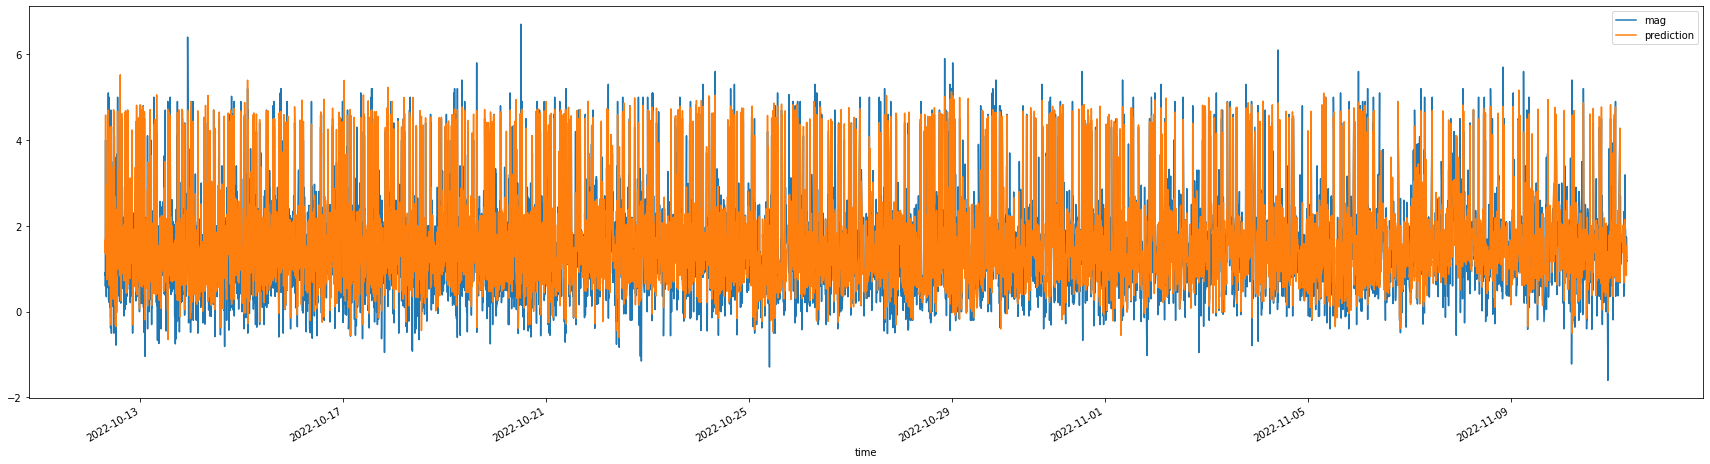

In [250]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction, 'time': live_data.time})
df_live = df_live.sort_values(by='time')
df_live.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [251]:
# model.save_model('../app/server/app/ml/model')